<a href="https://www.kaggle.com/code/yaaangzhou/what-laptops-are-people-using?scriptVersionId=134141970" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/laptop-specification-dataset/laptop_price (1).csv


# Imports

In [2]:
import numpy as np
import pandas as pd
import plotly.express as px

In [3]:
df = pd.read_csv('/kaggle/input/laptop-specification-dataset/laptop_price (1).csv',encoding = 'latin-1')
df.head()

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_in_euros
0,1,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69
1,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
2,3,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.00
3,4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.45
4,5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60


# Prepare Data

In [4]:
import re
def split_display_info(input_string):
    match = re.search(r'\d+', input_string)    
    if match:
        split_index = match.start()
        product = input_string[:split_index].strip()
        resolution = input_string[split_index:].strip()
    else:
        product = ""
        resolution = input_string.strip()
    
    return product, resolution

def split_memory_info(input_string):
    match = re.search(r'\d+', input_string)    
    if match:
        number = int(match.group())
    
    return number

def calcu_pixel(input_string):
    width, height = input_string.split('x')
    width = int(width)
    height = int(height)

    return width * height

In [5]:
df['Screen'] = df['ScreenResolution'].apply(lambda x:split_display_info(x)[0])
df['Resolution'] = df['ScreenResolution'].apply(lambda x:split_display_info(x)[1])

df.loc[df['Resolution'].str.contains('3840x2160',case=False), 'Resolution'] = '3840x2160' 

df['Memory_num'] = df['Memory'].apply(lambda x:split_memory_info(x))
df['Memory_num'] = df['Memory_num'].replace(1,1024)

df.loc[df['Memory'].str.contains('HDD', case=False), 'Memory_type'] = 'HDD'
df.loc[df['Memory'].str.contains('SSD', case=False), 'Memory_type'] = 'SSD'
df.loc[df['Memory'].str.contains('Flash Storage', case=False), 'Memory_type'] = 'Flash Storage'
df.loc[df['Memory'].str.contains('Hybird', case=False), 'Memory_type'] = 'Hybrid'
df.loc[df['Memory'].str.contains('Hybrid', case=False), 'Memory_type'] = 'Hybrid'

df['Ram'] = df['Ram'].str.replace('GB','')
df['Ram'] = df['Ram'].astype('int')
df['Weight'] = df['Weight'].str.replace('kg','')

df['Pixel'] = df['Resolution'].apply(lambda x:calcu_pixel(x))

df.drop(['ScreenResolution','Memory'],axis=1,inplace = True)

In [6]:
df.head()

,laptop_ID,Company,Product,TypeName,Inches,Cpu,Ram,Gpu,OpSys,Weight,Price_in_euros,Screen,Resolution,Memory_num,Memory_type,Pixel
0,1,Apple,MacBook Pro,Ultrabook,13.3,Intel Core i5 2.3GHz,8,Intel Iris Plus Graphics 640,macOS,1.37,1339.69,IPS Panel Retina Display,2560x1600,128,SSD,4096000
1,2,Apple,Macbook Air,Ultrabook,13.3,Intel Core i5 1.8GHz,8,Intel HD Graphics 6000,macOS,1.34,898.94,,1440x900,128,Flash Storage,1296000
2,3,HP,250 G6,Notebook,15.6,Intel Core i5 7200U 2.5GHz,8,Intel HD Graphics 620,No OS,1.86,575.00,Full HD,1920x1080,256,SSD,2073600
3,4,Apple,MacBook Pro,Ultrabook,15.4,Intel Core i7 2.7GHz,16,AMD Radeon Pro 455,macOS,1.83,2537.45,IPS Panel Retina Display,2880x1800,512,SSD,5184000
4,5,Apple,MacBook Pro,Ultrabook,13.3,Intel Core i5 3.1GHz,8,Intel Iris Plus Graphics 650,macOS,1.37,1803.60,IPS Panel Retina Display,2560x1600,256,SSD,4096000


# Boxplots

## Different companies with their products's price

In [7]:
fig = px.box(df,
             x="Company", 
             y="Price_in_euros",
             title='Different companies with their price')

fig.update_layout(
    xaxis_title='Marca',
    yaxis_title='Price',
    font=dict(
        family='Verdana',
        size=15,
        color='#02304a'
    )
)
fig.update_layout(template='plotly_white')

fig.show()

### ***As we can see here, Razer's products are much more expensive, even much more expensive than Apple. It's true: From a RazerBlade user.***

## Ram of different types of laptops

In [8]:
fig = px.box(df,
             x="TypeName", 
             y="Ram",
             title='Ram of different types of laptops')

fig.update_layout(
    xaxis_title='Marca',
    yaxis_title='Price',
    font=dict(
        family='Verdana',
        size=15,
        color='#02304a'
    )
)
fig.update_layout(template='plotly_white')

fig.show()

### ***The lowest average memory is Netbook, followed by Ultrabook. However, among ultrabooks, there are also products with up to 32gb of memory.***

### ***Let's take a look at it.***

In [9]:
df.query('Ram == 32 and TypeName == "Ultrabook"')

,laptop_ID,Company,Product,TypeName,Inches,Cpu,Ram,Gpu,OpSys,Weight,Price_in_euros,Screen,Resolution,Memory_num,Memory_type,Pixel
491,498,Toshiba,Portege X30-D-10L,Ultrabook,13.3,Intel Core i7 7500U 2.7GHz,32,Intel HD Graphics 620,Windows 10,1.05,2799.0,Full HD / Touchscreen,1920x1080,512,SSD,2073600


### ***Well...32GB ram with HD 620... such a waste.***
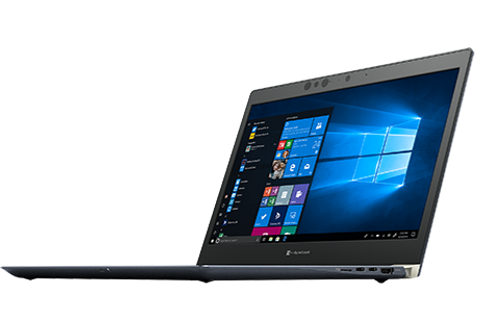
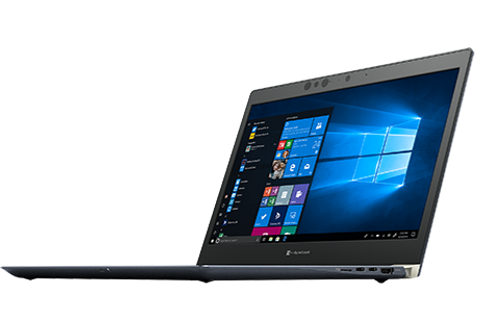
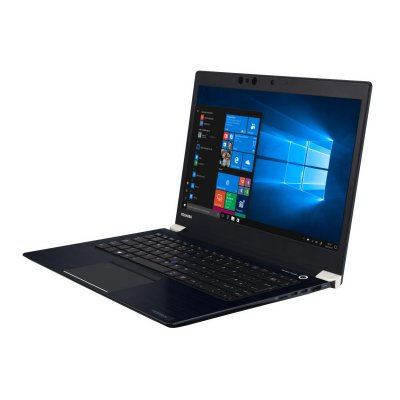
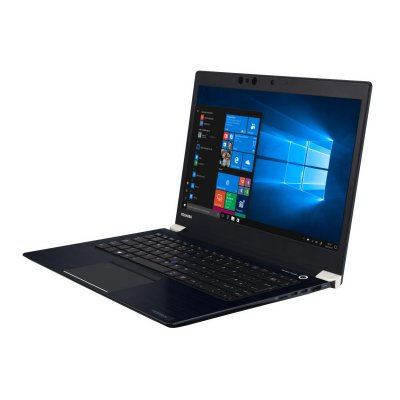
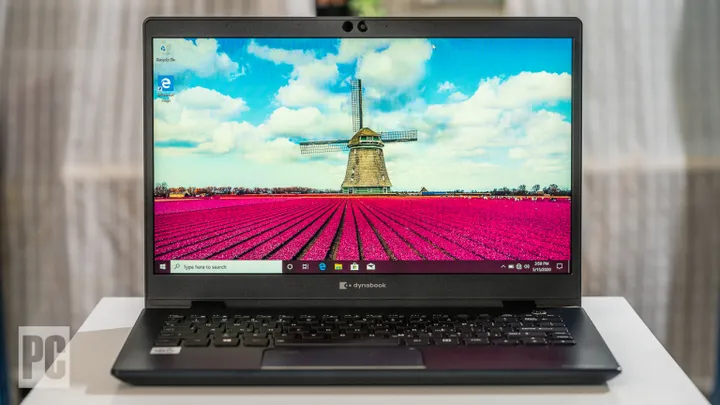

In [10]:
df.query('Ram == 64 and TypeName == "Gaming"')

,laptop_ID,Company,Product,TypeName,Inches,Cpu,Ram,Gpu,OpSys,Weight,Price_in_euros,Screen,Resolution,Memory_num,Memory_type,Pixel
1066,1081,Asus,ROG G701VO,Gaming,17.3,Intel Core i7 6820HK 2.7GHz,64,Nvidia GeForce GTX 980,Windows 10,3.58,3975.0,IPS Panel Full HD,1920x1080,1024,SSD,2073600


### ***I do remember this machine, it have been released for years.***
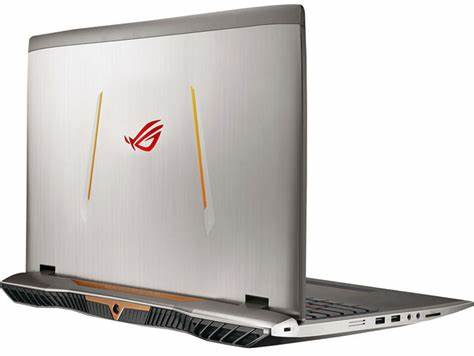

# Pieplot: How many products did each company release?

In [11]:
df_need = df.groupby(['Company']).agg({'laptop_ID':'count'}).reset_index()

fig = px.pie(df_need,values = 'laptop_ID',
             names = 'Company',
             title = 'Genre Distribution',
             color_discrete_sequence=px.colors.qualitative.Pastel,
             )
fig.update_traces(textposition='inside', textinfo='label+percent')
fig.update_layout(template='plotly_white')
fig.show()

### ***The three major computer manufacturers occupy the forefront: Lenovo, Dell, and HP.***

# Countplot: Different OS

In [12]:
fig = px.histogram(df, x='OpSys', 
                   color='Company',
                   color_discrete_sequence=px.colors.qualitative.Pastel,text_auto=True)
fig.update_xaxes(categoryorder='total descending')
fig.show()

### ***Laptop using Android???***

In [13]:
df.query('OpSys == "Android"')

,laptop_ID,Company,Product,TypeName,Inches,Cpu,Ram,Gpu,OpSys,Weight,Price_in_euros,Screen,Resolution,Memory_num,Memory_type,Pixel
50,51,Lenovo,Yoga Book,2 in 1 Convertible,10.1,Intel Atom x5-Z8550 1.44GHz,4,Intel HD Graphics 400,Android,0.69,319.0,IPS Panel Touchscreen,1920x1200,64,Flash Storage,2304000
1114,1129,Lenovo,Yoga Book,2 in 1 Convertible,10.1,Intel Atom x5-Z8550 1.44GHz,4,Intel HD Graphics 400,Android,0.69,549.0,IPS Panel Touchscreen,1920x1200,64,Flash Storage,2304000


### ***This is the andorid Laptop, looks no bad.***

## To be continued...